In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import rft_reconstruct_traj as rft
from scipy.io import loadmat

In [2]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

n_worms = len(tseries_w)

eigenworms_matrix = np.loadtxt('../data/Foraging_N2/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in tseries_w])
thetas_all = ma.vstack(thetas_w)

In [3]:
f = h5py.File('../data/labels_tree/labels_tree.h5','r')
delay = int(np.array(f['delay'])[0])
eigfunctions = np.array(f['eigfunctions'])
final_labels = ma.masked_invalid(np.array(f['final_labels'],dtype=int))
final_labels_mask = np.array(f['final_labels_mask'])
sel = final_labels_mask==1
final_labels[sel] = ma.masked
mlg = f['measures']
measures = []
for k in np.sort(list(mlg.keys())):
    measures.append(np.array(mlg[str(k)]))
labels_tree = np.array(f['labels_tree'],dtype=int)
f.close()

# characterize states

In [4]:
colors_states_ = ['#951622','#E30613','#F06600','#F09900','#312783','#1F77B4','#009FE3']
final_states = ['faststraight','fastscurved','slowdorsal','slowventral','dorsal turns','reversals','turns']
subdiv_dict = {'run':['slow','fast'],'fast':['fast_curved','fast_straight'],'slow':['dorsal','ventral'],
              'pirouette':['dorsal','ventral'],'ventral pirouettes':['reversals','turns']}

In [5]:
kmeans_labels = labels_tree[5,:]
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.masked_invalid(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

# Plot 10 min centroid trajectories

In [6]:
def rec_traj_from_sim(angleArray,L,dt,alpha=35.):
    theta = -angleArray
    ds = L/(theta.shape[0])
    skel = rt.get_skels(theta,L)
    X = skel[:,:,0]
    Y = skel[:,:,1]
    
    XCM, YCM, UX, UY, UXCM, UYCM, TX, TY, NX, NY, I, OMEG = rt.get_RBM(skel,L,ds,dt)
    DX, DY, ODX, ODY, VX, VY, Xtil, Ytil, THETA = rt.subtractRBM(X, Y, XCM, YCM, UX, UY, UXCM, UYCM, OMEG, dt)
    TX,TY = rt.lab2body(TX, TY, THETA)
    VX,VY = rt.lab2body(VX, VY, THETA)
    
    RBM = rt.posture2RBM(TX,TY,Xtil,Ytil,VX,VY,L,I,ds,alpha)
    XCM_recon,YCM_recon,THETA_recon = rt.integrateRBM(RBM,dt,THETA)
    Xrecon = np.vstack([XCM_recon,YCM_recon]).T
    return Xrecon

In [7]:
grid_xy = []
for kx,x in enumerate(np.arange(0,16,5)):
    for ky,y in enumerate(np.arange(0,11,5)):
        grid_xy.append([x,y])

0
1
2
3
4
5
6


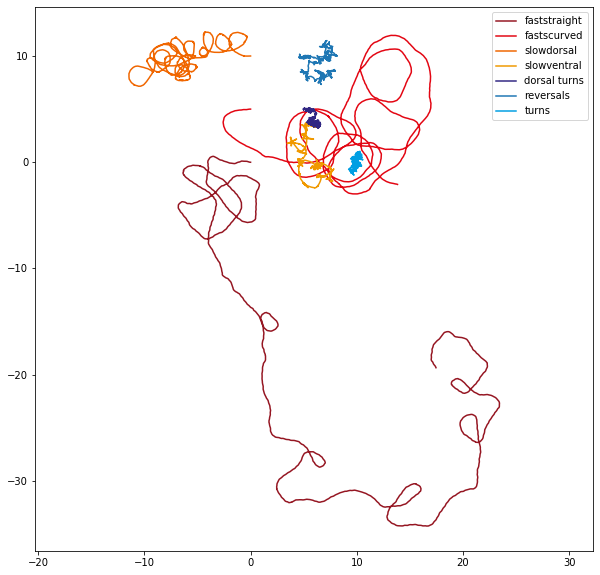

In [24]:
n_states=7
wsize = int(10*60*frameRate)
L=1
alpha=30.
ksim=1
t0 = int(5*60*frameRate)
plt.figure(figsize=(10,10))
for kstate in range(n_states):
    f = h5py.File('/bucket/StephensU/antonio/ForagingN2_data/animations/tseries_sims_state_{}.h5'.format(kstate),'r')
    ts = np.array(f['ts_smooth_sims'])[ksim]
    thetas = ts.dot(eigenworms_matrix[:,:5].T)
    f.close()    
    angleArray = thetas[t0:t0+wsize].T
    Xrecon =  rec_traj_from_sim(angleArray,L,dt,alpha=alpha)
    dx,dy = grid_xy[kstate]
    plt.plot(Xrecon[:,0]+dx,Xrecon[:,1]+dy,c=colors_states_[kstate],label=final_states[kstate])
    print(kstate)
plt.axis('equal')
plt.legend()
# plt.savefig('example_trajs.pdf')
plt.show()

# food search

In [8]:
n_states=7
ac_samples_state=[]
kinE_samples_state=[]
for kstate in range(n_states):
    f = h5py.File('../data/food_search/ac_samples_ks_{}.h5'.format(kstate),'r')
    ac_samples = np.array(f['ac_samples'])
    dist_range = np.array(f['dist_range'])
    kinE_samples = np.array(f['kinE_samples'])
    alpha = np.array(f['alpha'])[0]
    maxR = np.array(f['maxR'])[0]
    dr = np.array(f['dr'])[0]
    rmin = np.array(f['rmin'])[0]
    wsize = np.array(f['wsize'])[0]
    L = np.array(f['L'])[0]
    stride_t = np.array(f['stride_t'])[0]
    stride_ds = np.array(f['stride_ds'])[0]
    f.close()
    ac_samples_state.append(ac_samples)
    kinE_samples_state.append(kinE_samples)

In [9]:
alpha

30.0

In [10]:
ac_samples_state = np.array(ac_samples_state)

In [12]:
f = h5py.File('../data/labels_tree/labels_tree.h5','r')
mlg = f['measures']
measures = []
for k in np.sort(list(mlg.keys())):
    measures.append(np.array(mlg[str(k)]))
f.close()

In [13]:
measures[-1]

array([0.21029301, 0.17858261, 0.21917069, 0.14591984, 0.01947285,
       0.13232389, 0.09418533], dtype=float32)

In [14]:
ac_samples_ratio = (ac_samples_state/np.sum(ac_samples_state,axis=0))

In [15]:
ac_avg_worm = np.sum([ac_samples_ratio[ks]*measures[-1][ks] for ks in range(n_states)],axis=0)

In [16]:
ac_avg_worm.shape

(1000, 30)

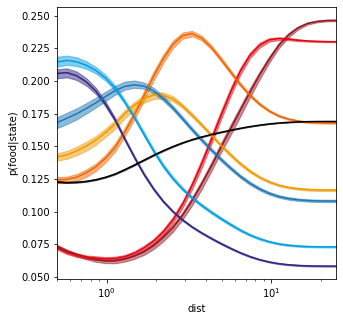

In [17]:
plt.figure(figsize=(5,5))
for ks in range(n_states):
    ac_samples = (ac_samples_state/np.sum(ac_samples_state,axis=0))[ks]
    mean,cil,ciu = stats.bootstrap(ac_samples,n_times=100)
    plt.plot(dist_range,mean,c=colors_states_[ks])
    plt.fill_between(dist_range,cil,ciu,alpha=.5,color=colors_states_[ks])
mean,cil,ciu = stats.bootstrap(ac_avg_worm,n_times=100)
plt.plot(dist_range,mean,c='k')
plt.fill_between(dist_range,cil,ciu,alpha=.5,color='k')
plt.xscale('log')
plt.xlim(.5,25)
# plt.ylim(,0.3)
plt.ylabel('p(food|state)')
plt.xlabel('dist')
# plt.savefig('prob_food_given_state.pdf')
plt.show()

In [19]:
cluster_traj_w = cluster_traj.reshape((12,33600))
measures_w = np.zeros((n_worms,n_states))
for kw in range(n_worms):
    counts_state = np.array([(cluster_traj_w[kw]==ks).sum() for ks in range(n_states)])
    probs_state = counts_state/counts_state.sum()
    measures_w[kw] = probs_state
mean_mu,cil_mu,ciu_mu = stats.bootstrap(measures_w,n_times=5000)

In [20]:
ac_state = (ac_samples_state[:,:,-1]/np.sum(ac_samples_state,axis=0)[:,-1])

In [21]:
mean = ac_state.mean(axis=1)
cil = np.percentile(ac_state,2.5,axis=1)
ciu = np.percentile(ac_state,97.5,axis=1)

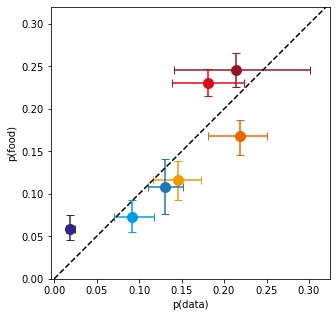

In [29]:
plt.figure(figsize=(5,5))
for ks in range(n_states):
    plt.errorbar(mean_mu[ks],mean[ks],xerr = [[mean_mu[ks]-cil_mu[ks]],[ciu_mu[ks]-mean_mu[ks]]],yerr = [[mean[ks]-cil[ks]],[ciu[ks]-mean[ks]]],capsize=4,ms=10,marker='o',fmt='o',c=colors_states_[ks])
plt.plot(np.linspace(0,.35),np.linspace(0,.35),c='k',ls='--')
plt.ylabel('p(food)')
plt.xlabel('p(data)')
plt.axis('equal')
plt.xlim(0,.32)
plt.ylim(0,.32)
# plt.savefig('measures_vs_food_prob.pdf')
plt.show()